# Preprocessing for FFTs

Here, we examine various steps that may be used to preprocess a waveform before applying a Fast Fourier Transform (FFT).  The goal is to improve the quality of the FFT output, which may be used for further analysis or visualization.  While many techniques from signal processing are applicable, analyzing models of gravitational waves from merging binaries presents some unique challenges:

  * The signals "chirp" — increase in both amplitude and frequency — as they approach merger.
  * The signals will also often contain memory — meaning that whereas they may oscillate around zero before merger, they settle down to some nonzero value after merger.
  * For model waveforms there is essentially no noise, though numerical errors may be present.

These factors lead us to make some unusual choices in processing our data.  We will examine the following steps:

  1. **Interpolation**: Sampling the data at a uniform time-step size.
  2. **Tapering**: Applying a window function to the waveform before taking the FFT.
  3. **Transition to constant**: Ensure that the ringdown approaches a constant value at late times.
  4. **Padding**: Include more data into the waveform before taking the FFT.
  5. **Line subtraction**: Remove a linear trend from the waveform.

These steps are examined carefully — and specifically in view of the treatment of memory — in [this paper](https://arxiv.org/abs/2405.06197).  This notebook is intended to provide a practical guide to implementing these steps with the `sxs` package.

For the impatient: all of these steps, along with sensible defaults, can be run at once with the `preprocess` method of waveforms loaded by the `sxs` package.

# Loading and interpolating data

For the sake of example, we load a waveform from the SXS catalog.  The current catalog, containing extrapolated data, does not include memory, so we will [add it](https://arxiv.org/abs/2011.01309) using the `add_memory` function.  We then interpolate this waveform to a uniform time-step size, which is necessary for the FFT.  For simplicity, we choose the time-step size as the smallest time step in the original data; more common choices might include interpolating to standard sampling rates after converting to physical units with some chosen total mass.  Finally, we will evaluate the waveform in a particular direction, as it would be observed in a detector.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sxs

# Load a waveform with a lot of memory; choose N=4 to ensure that ringdown is ugly
sxs_bbh_1124 = sxs.load("SXS:BBH:1124", extrapolation="N4")
w_raw = sxs_bbh_1124.h

# Add memory, because extrapolated data does not contain it (unlike CCE)
w = sxs.waveforms.memory.add_memory(w_raw)

# Interpolate to a regular time grid
dt = np.min(np.diff(w.t))
w_interpolated = w.interpolate(np.arange(w.t[0], w.t[-1], dt))

# Choose a direction that will really show off the memory
θ, ϕ = np.pi/2, 0.0
h = w_interpolated.evaluate(θ, ϕ)

This system happens to be non-precessing, but has very large spins aligned with the angular momentum.  This means that the "orbital hangup" will allow it to emit large amounts of energy, resulting in a very strong memory signal.  Evaluated in the orbital plane, $\theta = \pi/2$, the $h_\times$ component should be zero, while the memory component will be strongly emphasized:

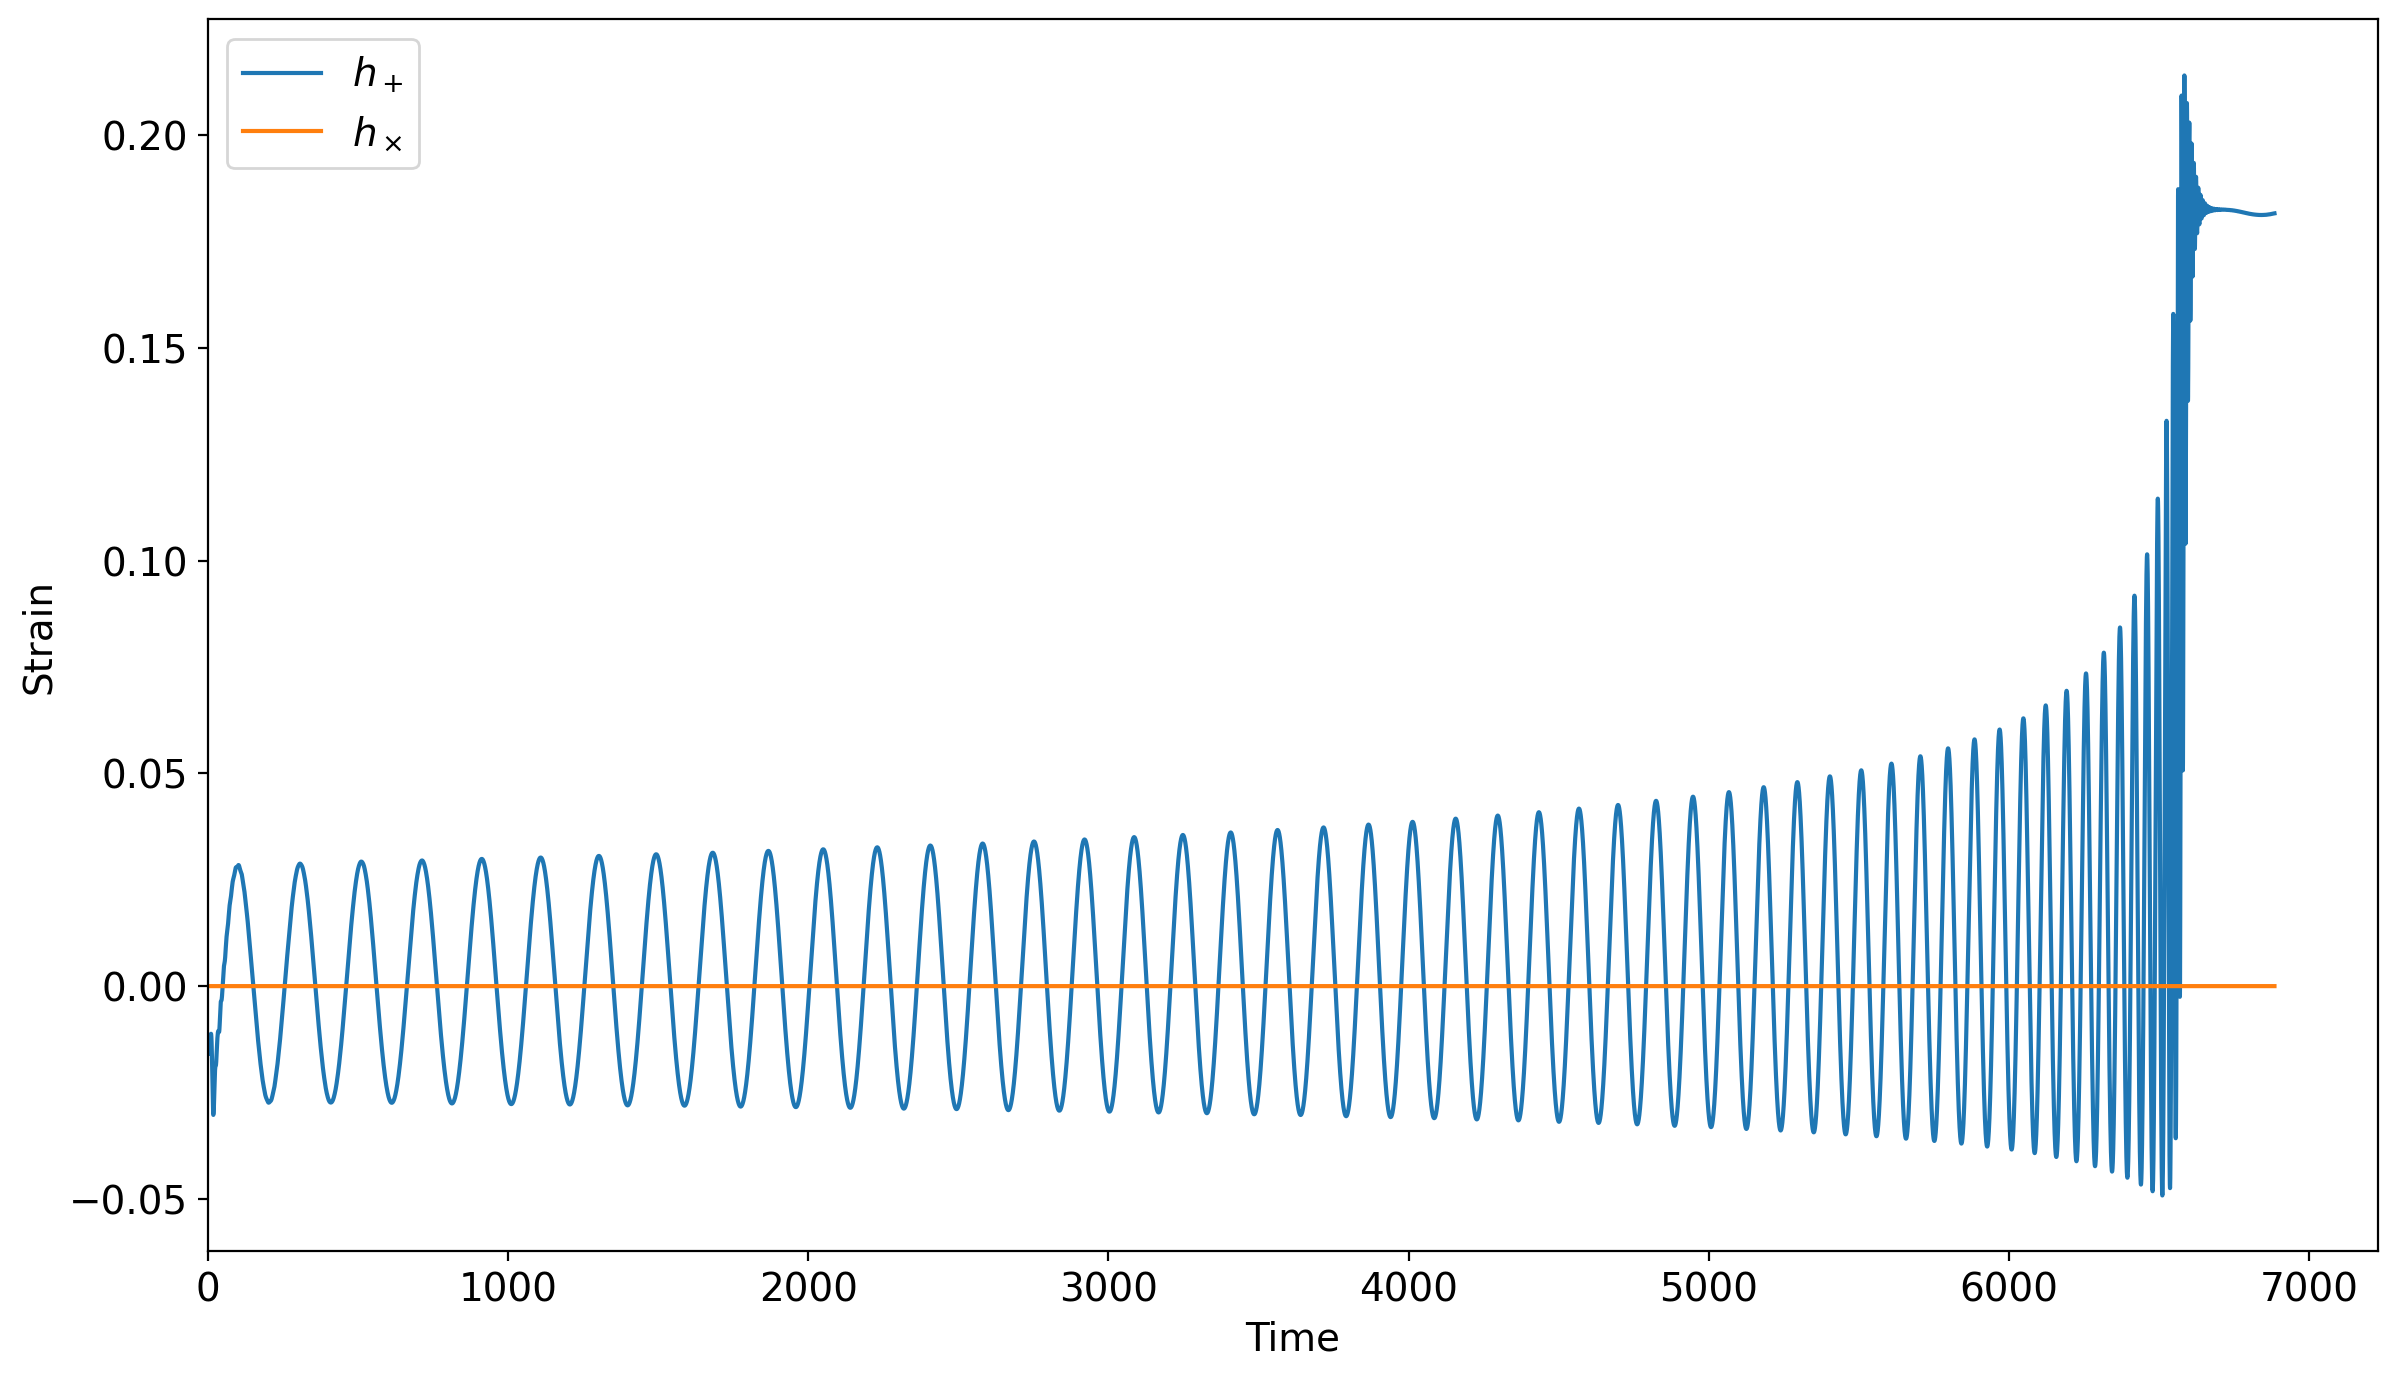

In [2]:
plt.plot(h.t, h.real, label=r"$h_+$")
plt.plot(h.t, -h.imag, label=r"$h_\times$")
plt.xlabel("Time")
plt.ylabel("Strain")
plt.xlim(xmin=0)
plt.legend();

Note that we have chosen extrapolation order $N=4$, which leads to more accurate inspiral, but instability during ringdown.  We do this intentionally to demonstrate how to handle poor numerical behavior in the ringdown, using the "transition to constant" step below.

## Window functions and tapering

Windowing is an entirely standard technique in signal processing.  The primary goal is to limit the effects of the finite length of the data on the FFT.  The FFT assumes that the data is periodic, and so if the data is not periodic, the FFT will see a discontinuity at the edges of the data.  This discontinuity will lead to spectral leakage, where power from one frequency bin leaks into other frequency bins.  Notably, in standard signal processing, most windows are typically changing constantly; there is no region over which the window is constant.  For example, the standard "Hann" window is essentially $\sin^2(\pi t / T)$, where $T$ is the total length of the signal.

The fact that merging binaries *chirp* is fairly unusual in signal processing.  We can think in terms of the [stationary-phase approximation](https://en.wikipedia.org/wiki/Stationary_phase_approximation), and consider that (at least during the inspiral) each point *in time* corresponds fairly cleanly to a point *in frequency*.  Thus, if we want to accurately represent the signal over some sensitive frequency band, we should use a window that is *constant* over the corresponding region in time, rather than constantly changing like most window functions.

The two standard choices of windows that are constant over a significant range are the cosine-taper or Tukey window, and the smooth compact tanh window (sometimes fallaciously called the "Planck-taper" window — despite having nothing to do with Planck, nor resembling his distribution).  Note that the cosine window actually has slightly *better* characteristics than the smooth window in practice, providing smaller spectral leakage except asymptotically, where the leakage is sure to be lost in noise and numerical error anyway.  Nonetheless, the gravitational-wave community seems to prefer the smooth window, so that is the default for the `sxs` package.

Waveforms in the `sxs` package have a `window` method that will return a copy of the data windowed appropriately.  Here, we can see what the two windows look like.  Note that both are controlled by a set of parameters indicating when the window begins to increase from zero (`t1`), when it reaches 1 (`t2`), when it begins to decrease from 1 (`t3`), and when it reaches zero again (`t4`).

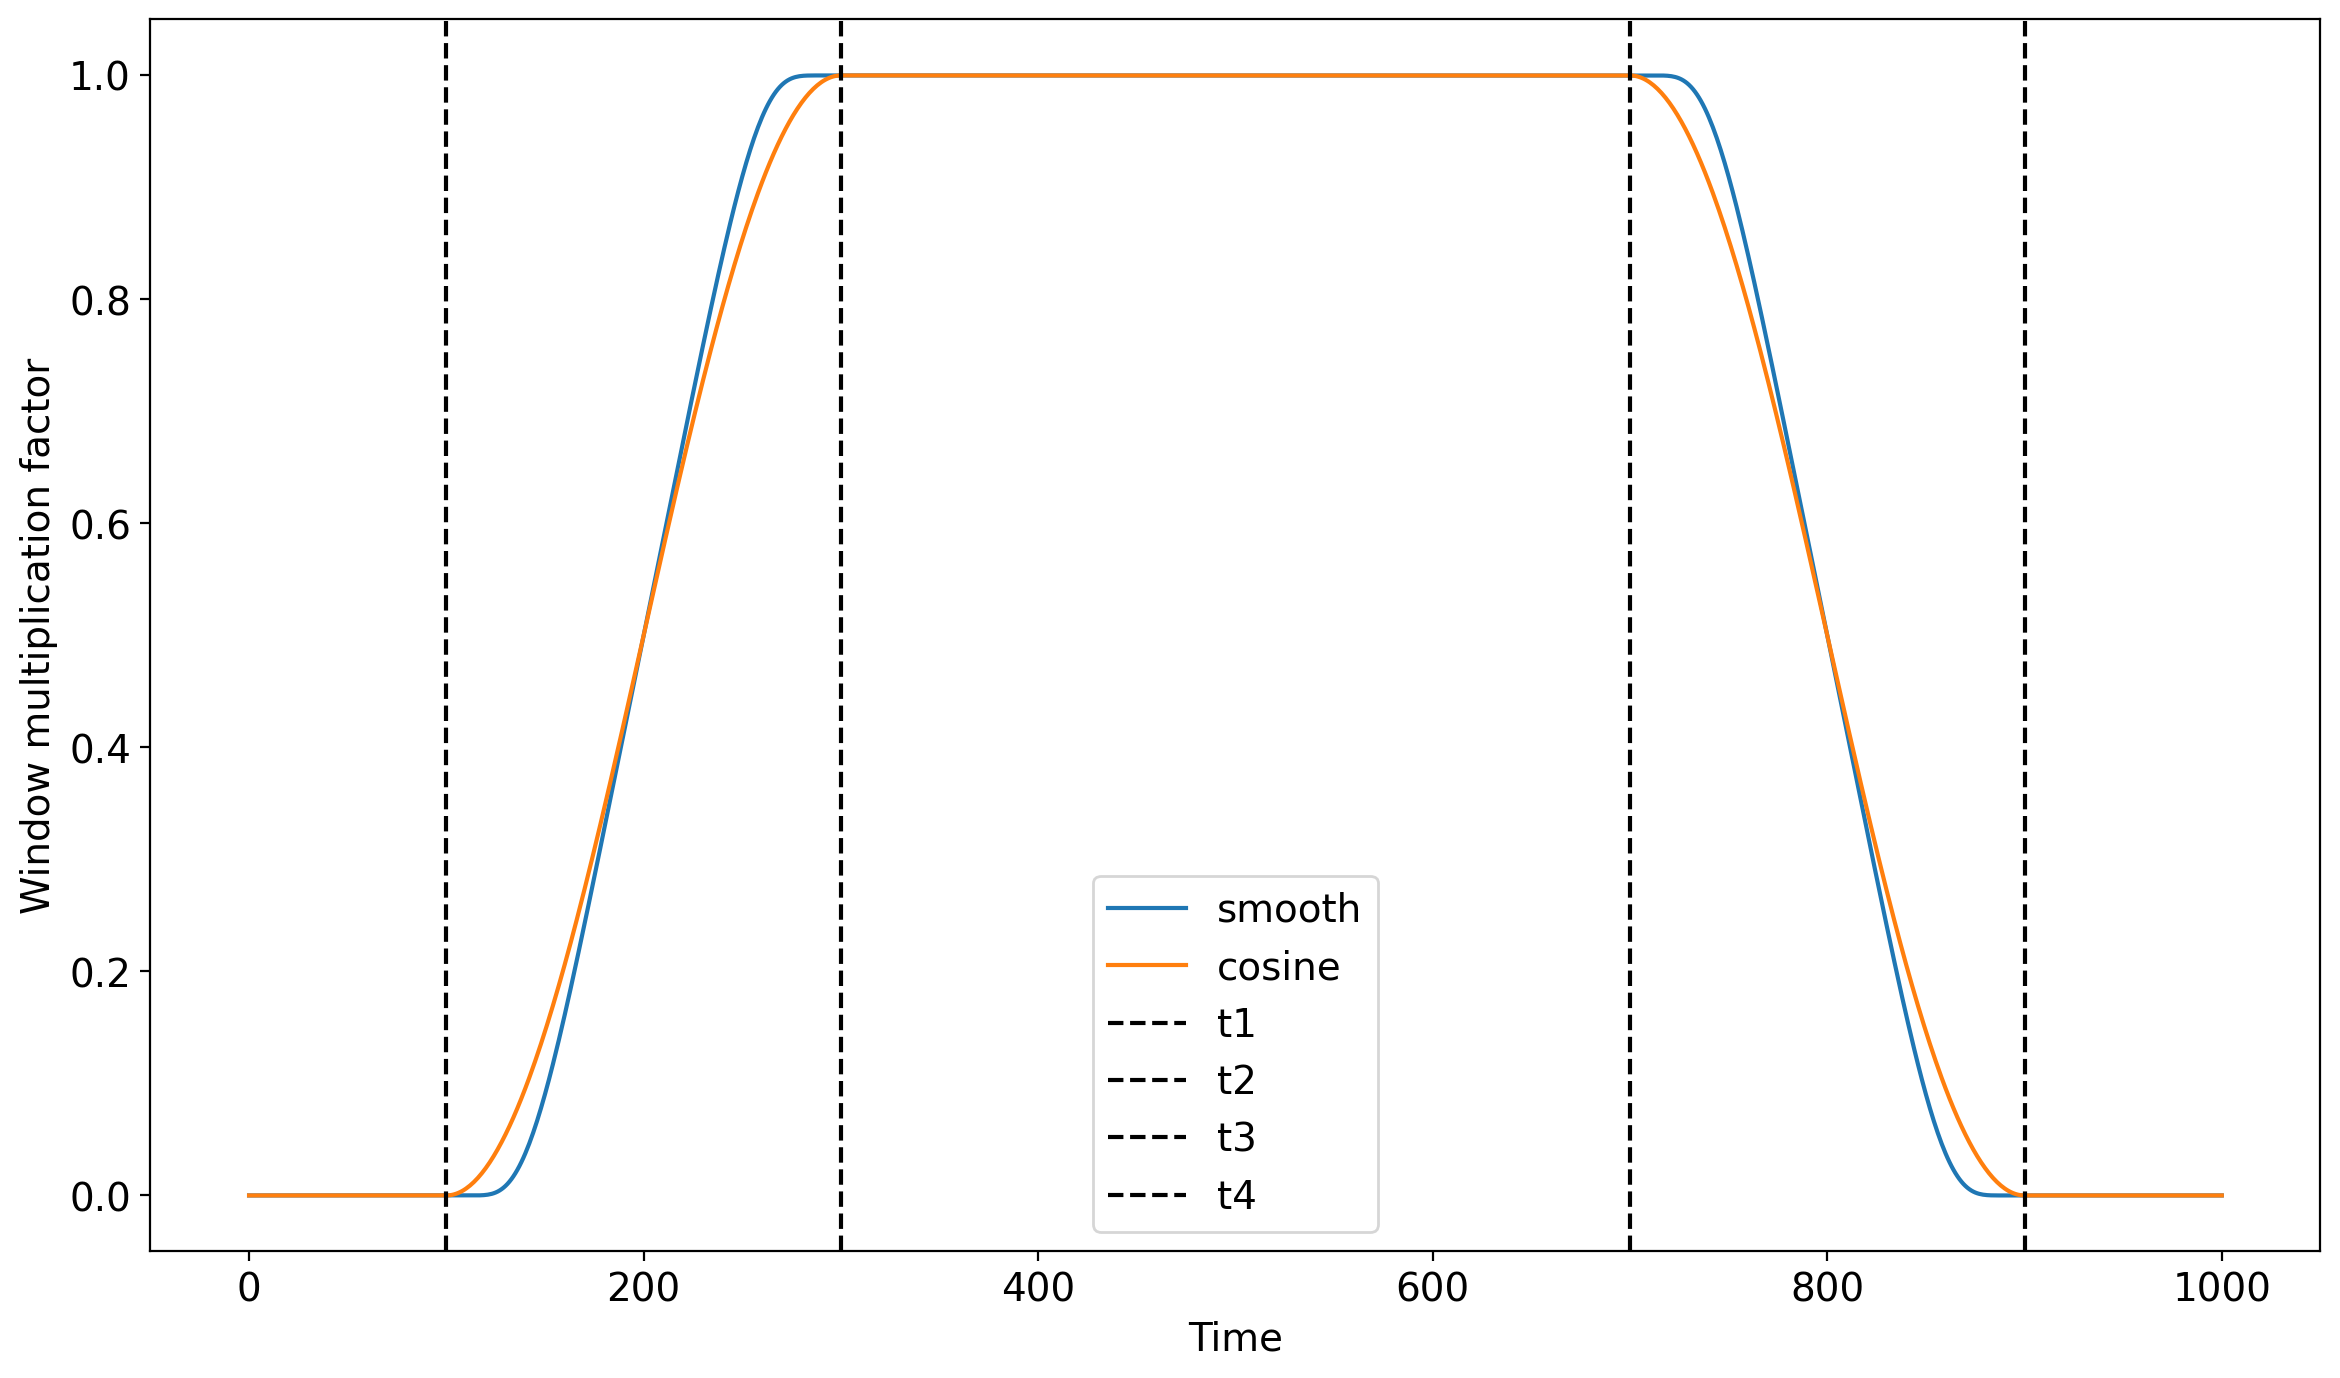

In [3]:
t1 = 100.0
t2 = 300.0
t3 = 700.0
t4 = 900.0
t = np.linspace(0.0, 1000.0, 1001)

unwindowed = sxs.TimeSeries(np.ones_like(t), t)  # Just example data that's all 1's
windowed_smooth = unwindowed.window(t1, t2, t3, t4)
windowed_cosine = unwindowed.window(t1, t2, t3, t4, window_type="cosine")

plt.plot(windowed_smooth.t, windowed_smooth.ndarray, label="smooth")
plt.plot(windowed_cosine.t, windowed_cosine.ndarray, label="cosine")
plt.axvline(t1, color="k", linestyle="--", label="t1")
plt.axvline(t2, color="k", linestyle="--", label="t2")
plt.axvline(t3, color="k", linestyle="--", label="t3")
plt.axvline(t4, color="k", linestyle="--", label="t4")
plt.xlabel("Time")
plt.ylabel("Window multiplication factor")
plt.legend();

However, for signals with memory, we may not want the window at later times to zero out the data,eliminating at least some of the memory.  In particular, the rationale for using a window with a chirp — that it affects the frequency-domain signal in a limited band — does not apply when modifying the late-time memory signal.  Rather, we want to taper the beginning of the data (the portion containing the chirp), and leave the memory portion alone.  We *could* achieve this by adjusting the `t3` and `t4` parameters to be beyond the end of the data, but more simply we can just use the `taper` method:

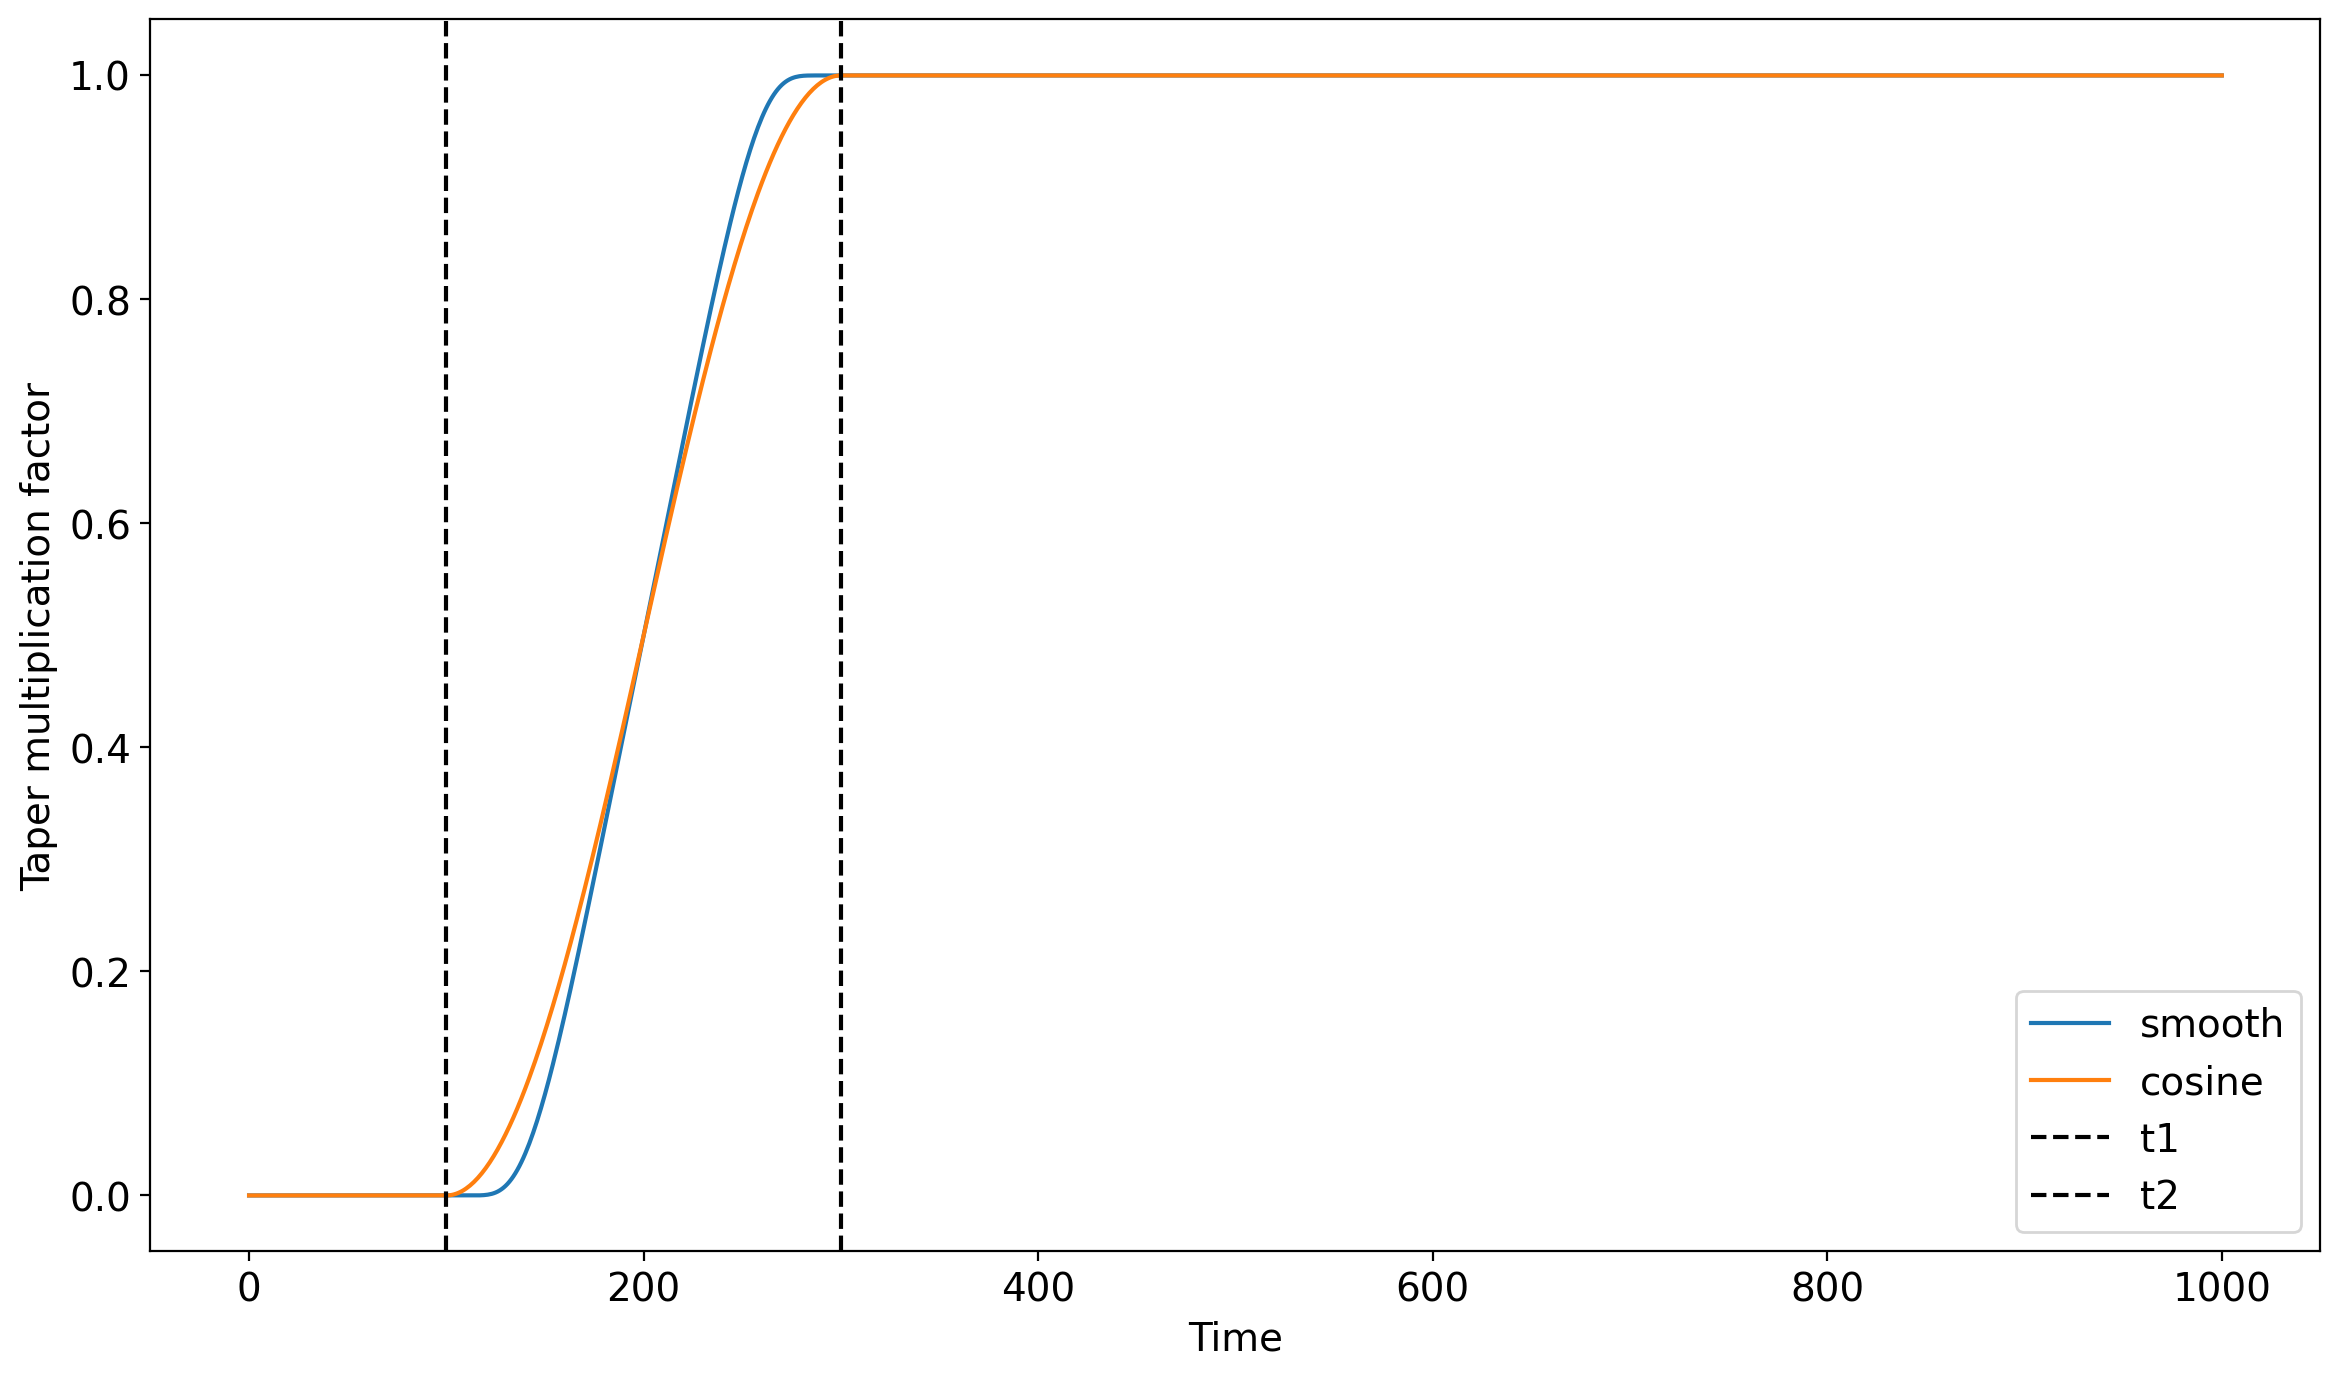

In [4]:
tapered_smooth = unwindowed.taper(t1, t2)
tapered_cosine = unwindowed.taper(t1, t2, transition_type="cosine")

plt.plot(tapered_smooth.t, tapered_smooth.ndarray, label="smooth")
plt.plot(tapered_cosine.t, tapered_cosine.ndarray, label="cosine")
plt.axvline(t1, color="k", linestyle="--", label="t1")
plt.axvline(t2, color="k", linestyle="--", label="t2")
plt.xlabel("Time")
plt.ylabel("Taper multiplication factor")
plt.legend();

For waveform data, we will typically want to start the taper with `t1=0`, and then choose some value for `t2` that is both reasonably large to avoid Gibbs effects, while being small enough to accurately capture a significant portion of the inspiral.  For this example, we might choose `t2=500`:

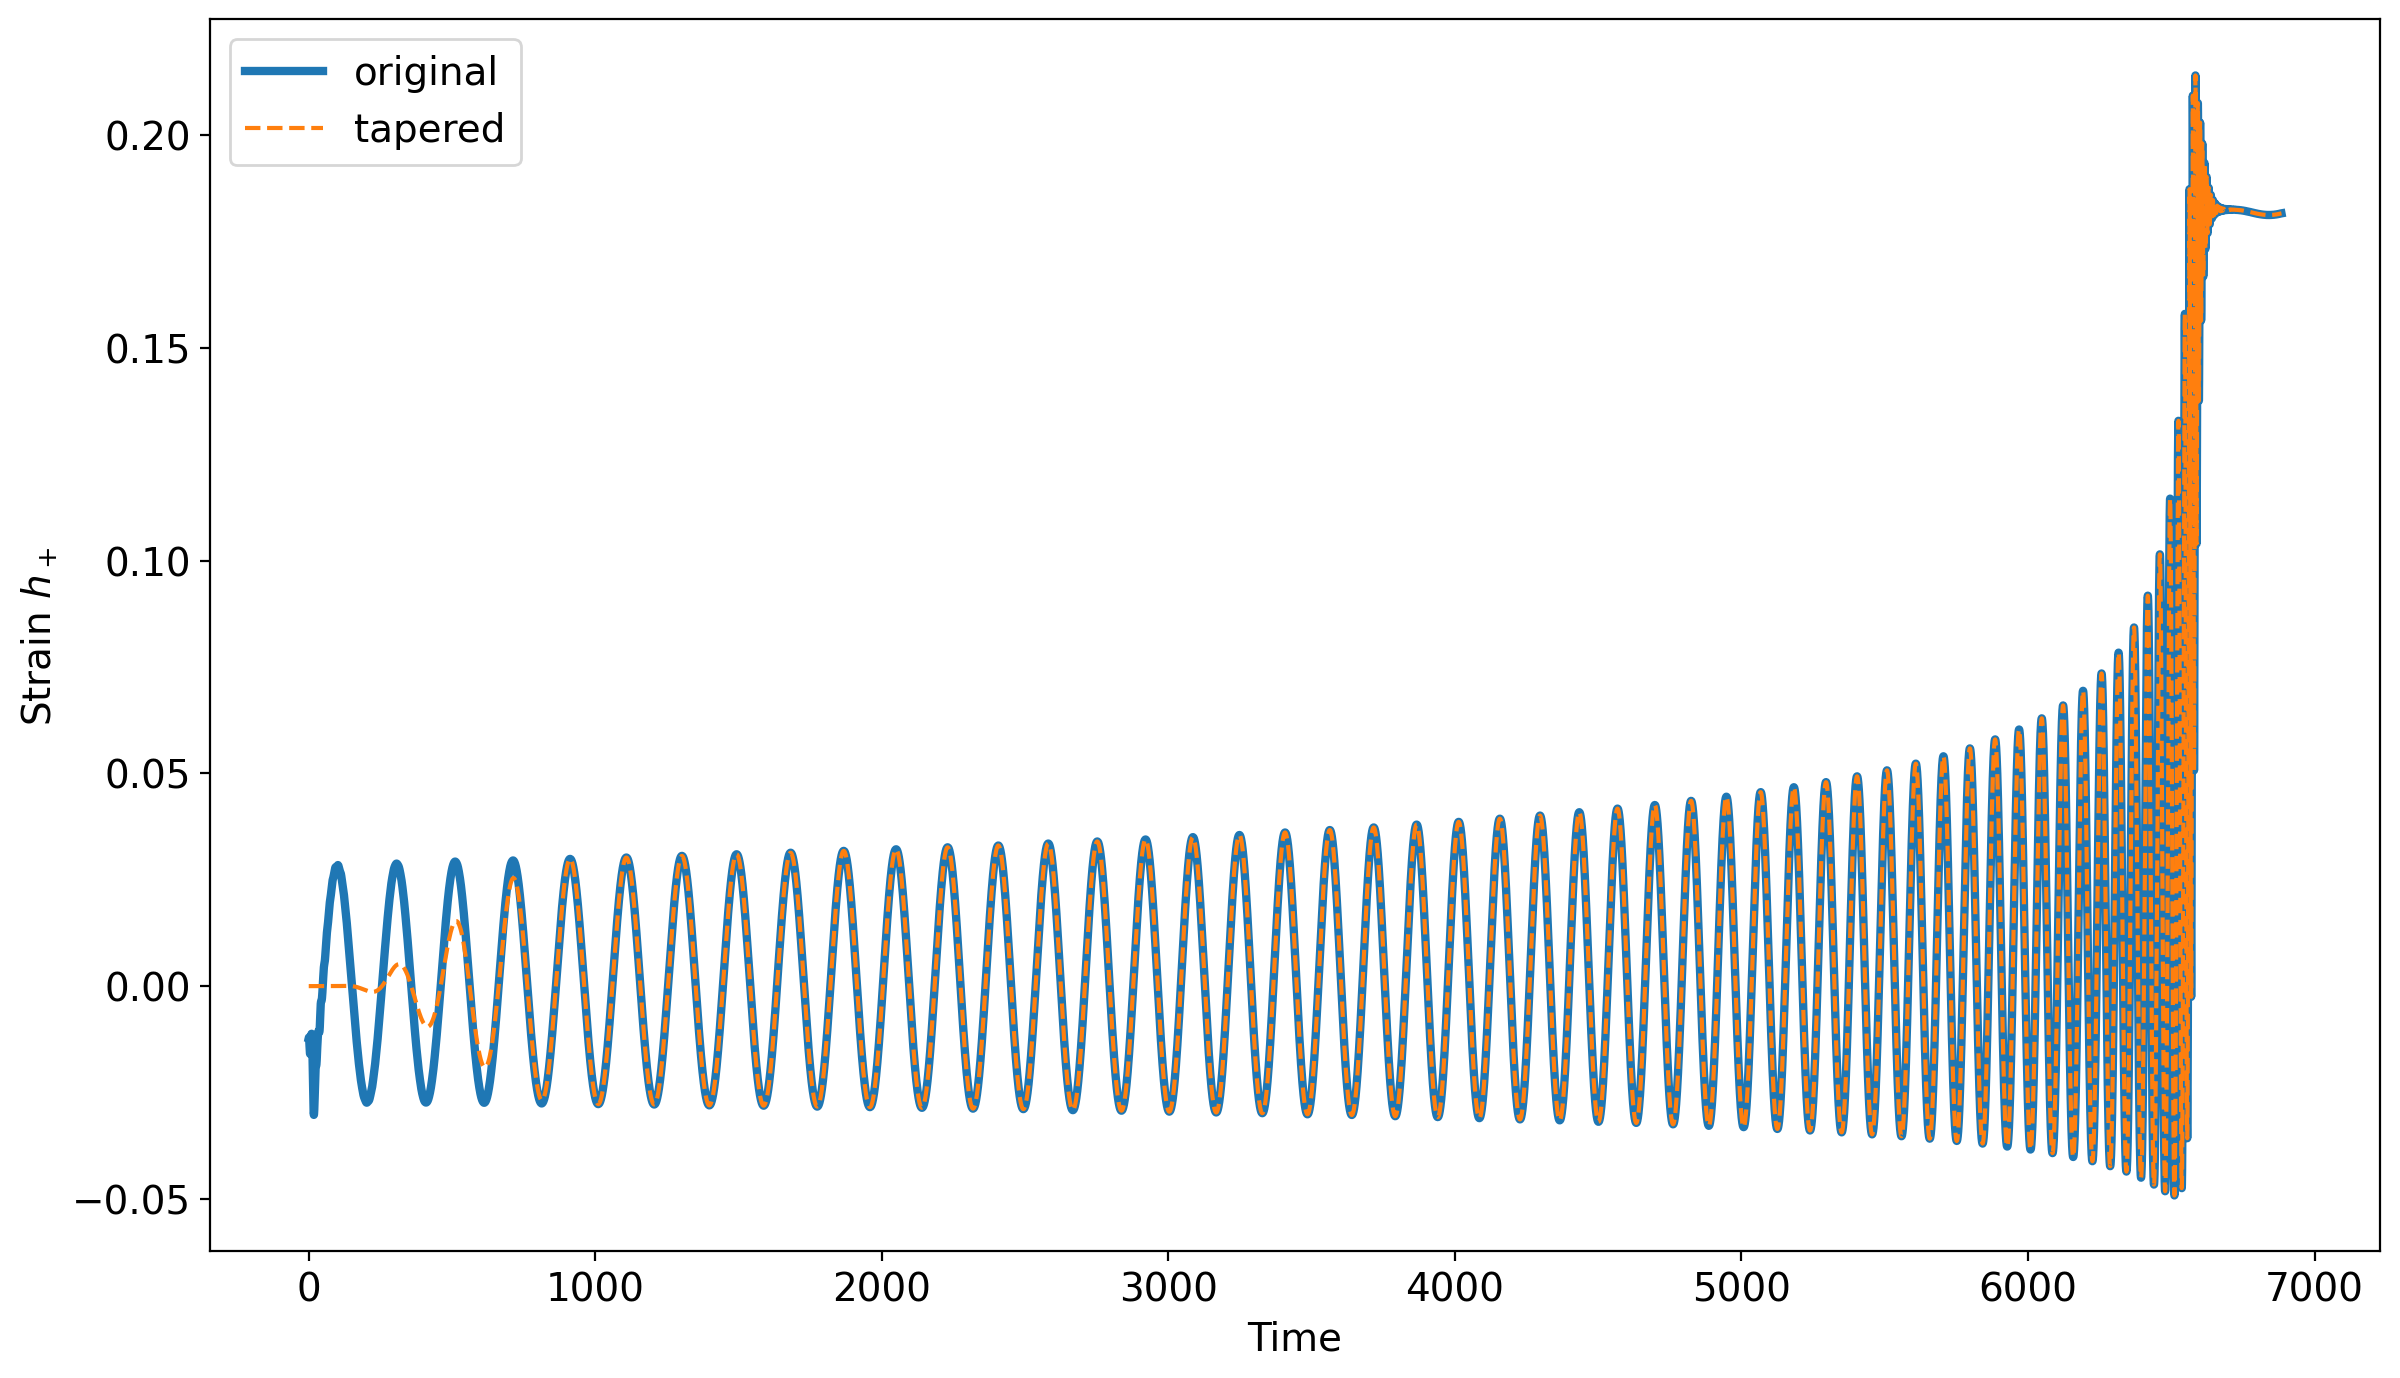

In [5]:
h_tapered = h.taper(0, 1000)

plt.plot(h.t, h.real, lw=3, label="original")
plt.plot(h_tapered.t, h_tapered.real, ls="--", label="tapered")
plt.xlabel("Time")
plt.ylabel("Strain $h_+$")
plt.legend();

# Transitioning to a constant value

While our standard idea of the ringdown of a black hole is a simple exponential decay to zero, the presence of memory means that the final value of the waveform is not zero.  Moreover, numerical errors can cause dynamical behavior that makes it difficult or impossible to provide a smooth transition back to the beginning of the periodic signal in preparation for the FFT.  In fact, we chose to load the waveform with `extrapolation="N4"` to emphasize this bad numerical behavior in the ringdown.

In this case, we don't want to taper the waveform to zero, but rather to some constant value, and to do so smoothly.  This can be done using the `transition_to_constant` method, which simply tapers the *derivative of the data* to zero.  The precise final value is not important, as long as the function is constant, so that we may match it to the beginning of the data in the next step.

Again, the method has two parameters, denoting when to begin the transition and when to end it.  Here, we simply begin it $100M$ after the merger (defined as the maximum of the $L^2$ norm of the original data), and end it $200M$ after merger.  (This is generally a fairly good choice for SXS data in the current catalog.)

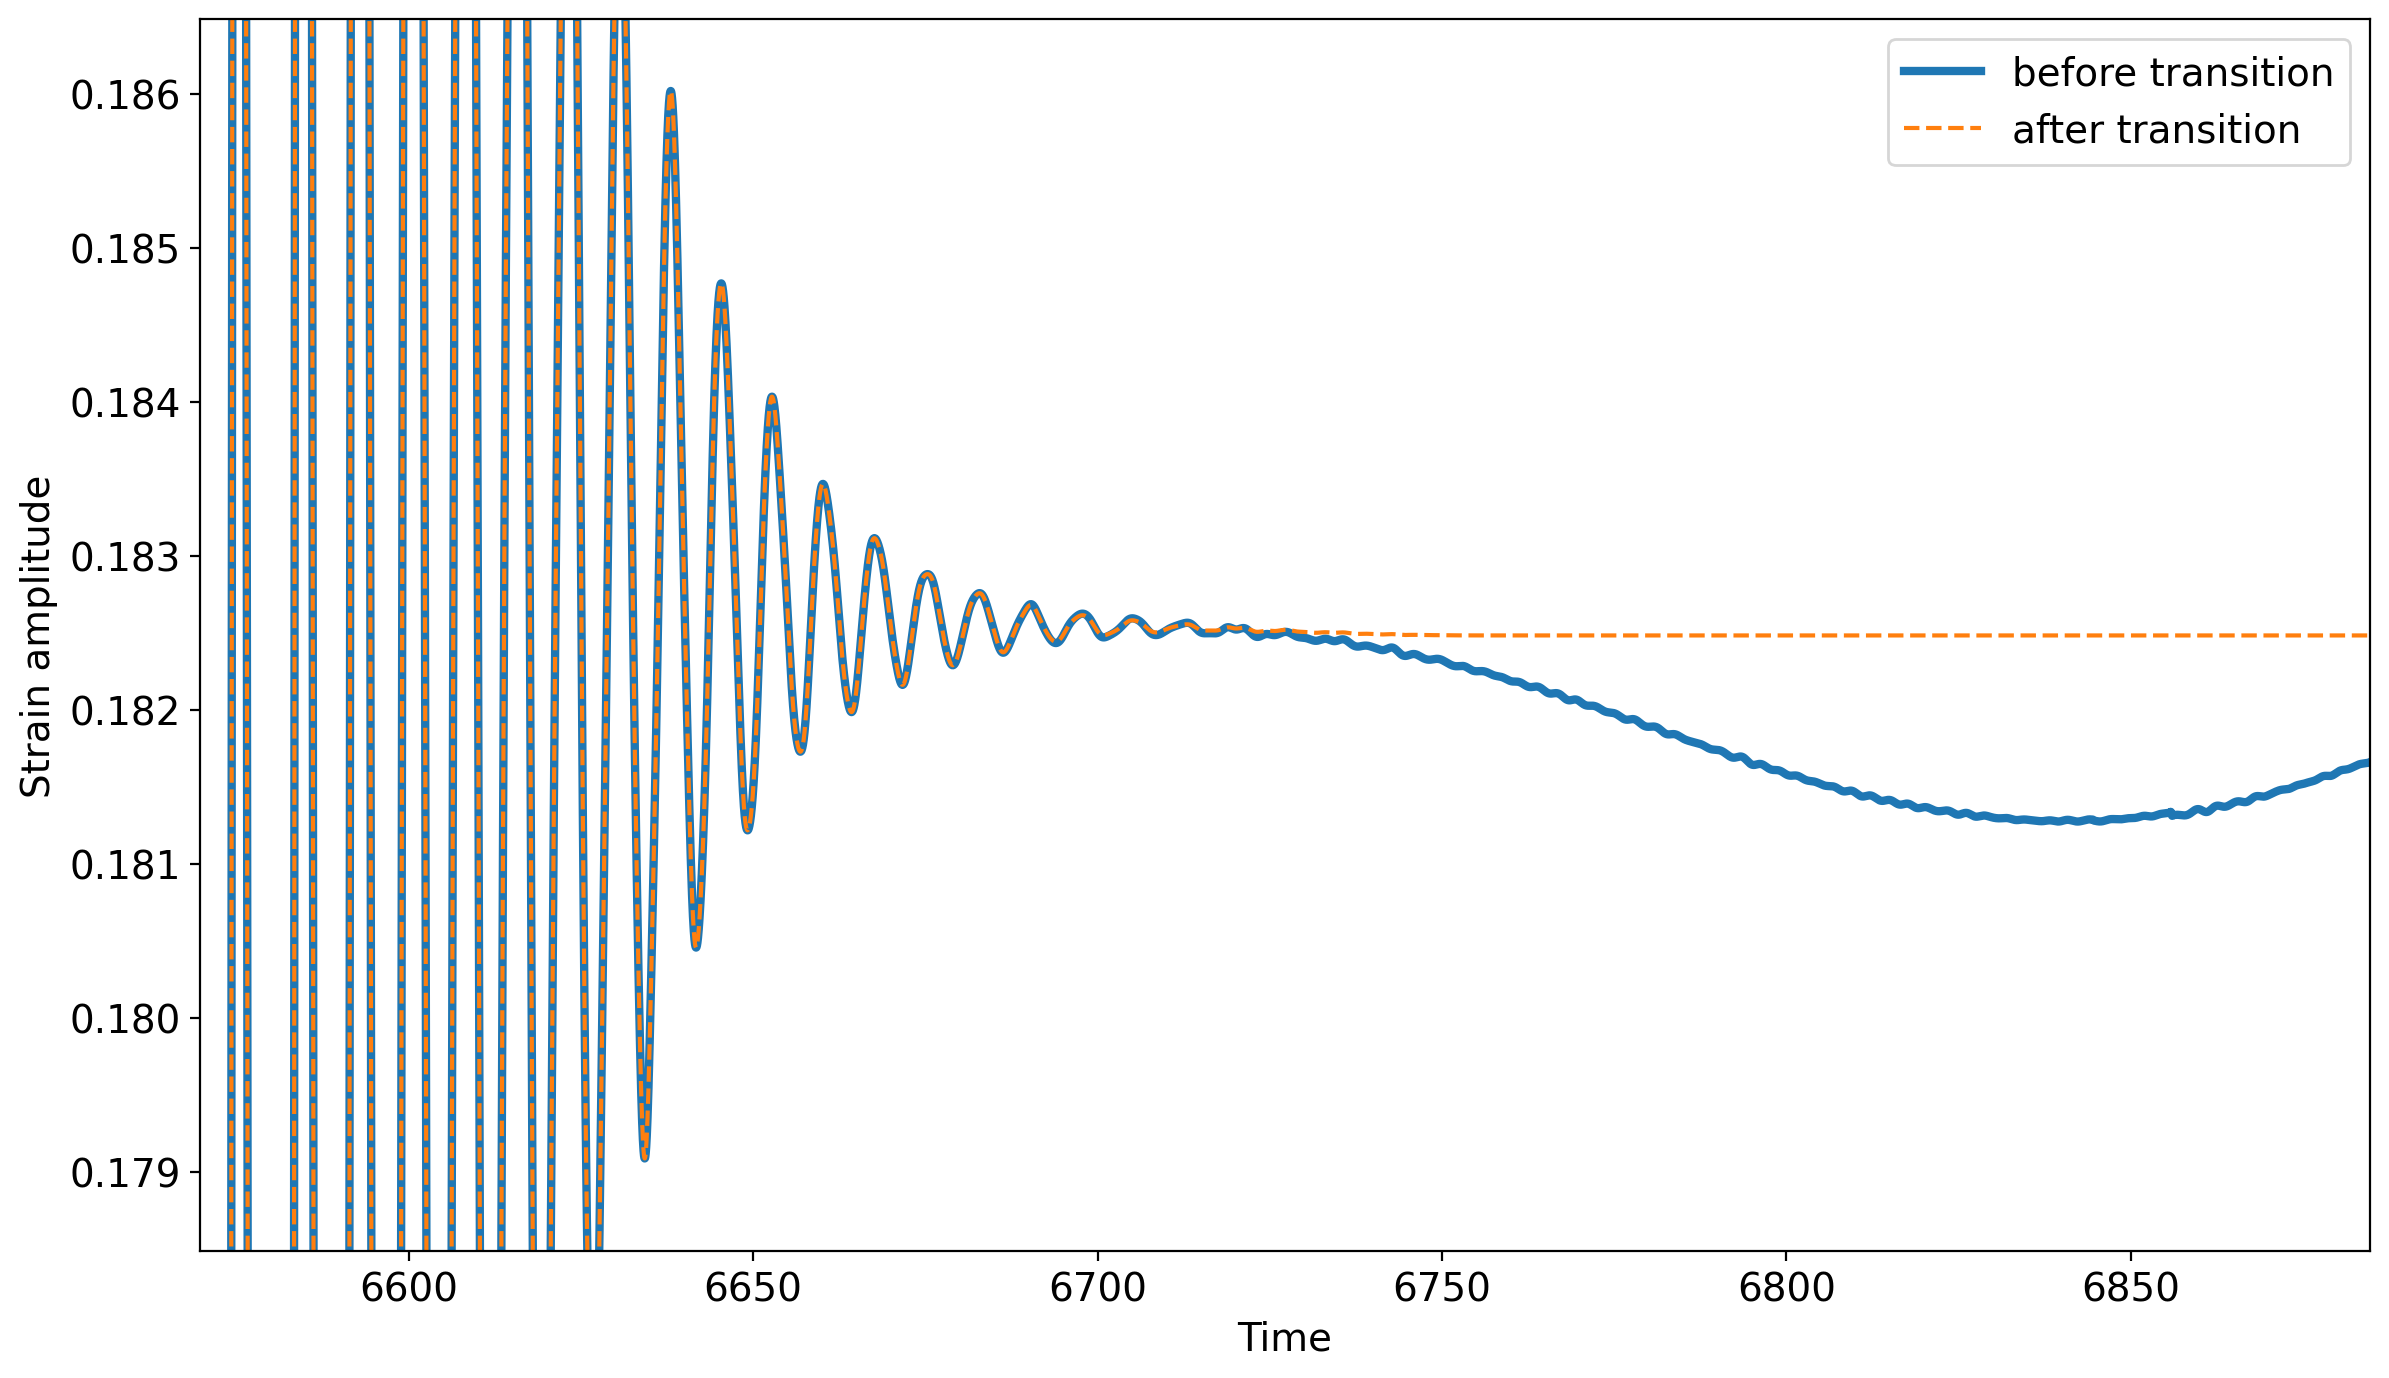

In [6]:
h_transitioned = h_tapered.transition_to_constant(w.max_norm_time()+100, w.max_norm_time()+200)

y_f = h_transitioned[-1].real
plt.plot(h_tapered.t, h_tapered.real, lw=3, label="before transition")
plt.plot(h_transitioned.t, h_transitioned.real, ls="--", label="after transition")
plt.xlim(w.max_norm_time(), h_transitioned.t[-1])
plt.ylim(y_f - 4e-3, y_f + 4e-3)
plt.xlabel("Time")
plt.ylabel("Strain amplitude")
plt.legend();

# Padding

Padding is a standard technique in signal processing, where we add zeros to the end of the data before taking the FFT.  This effectively interpolates the data to higher frequency resolution.  Perhaps more importantly, though, it can provide a larger time span over which optimization of the time offset may be achieved by standard FFT-based methods (see the [paper](https://arxiv.org/abs/2405.06197) for details).

In our case, we want to pad before the beginning of the data with the initial data value — which is just 0 when we have tapered from 0 — and after the end of the data with the final data value.  The `pad` method for waveforms in the `sxs` module does this automatically.  The only parameter is the amount of time to pad on each side.  Here, because the data is already pretty much centered in the time domain, we will pad it symmetrically by $6000M$ on both sides:

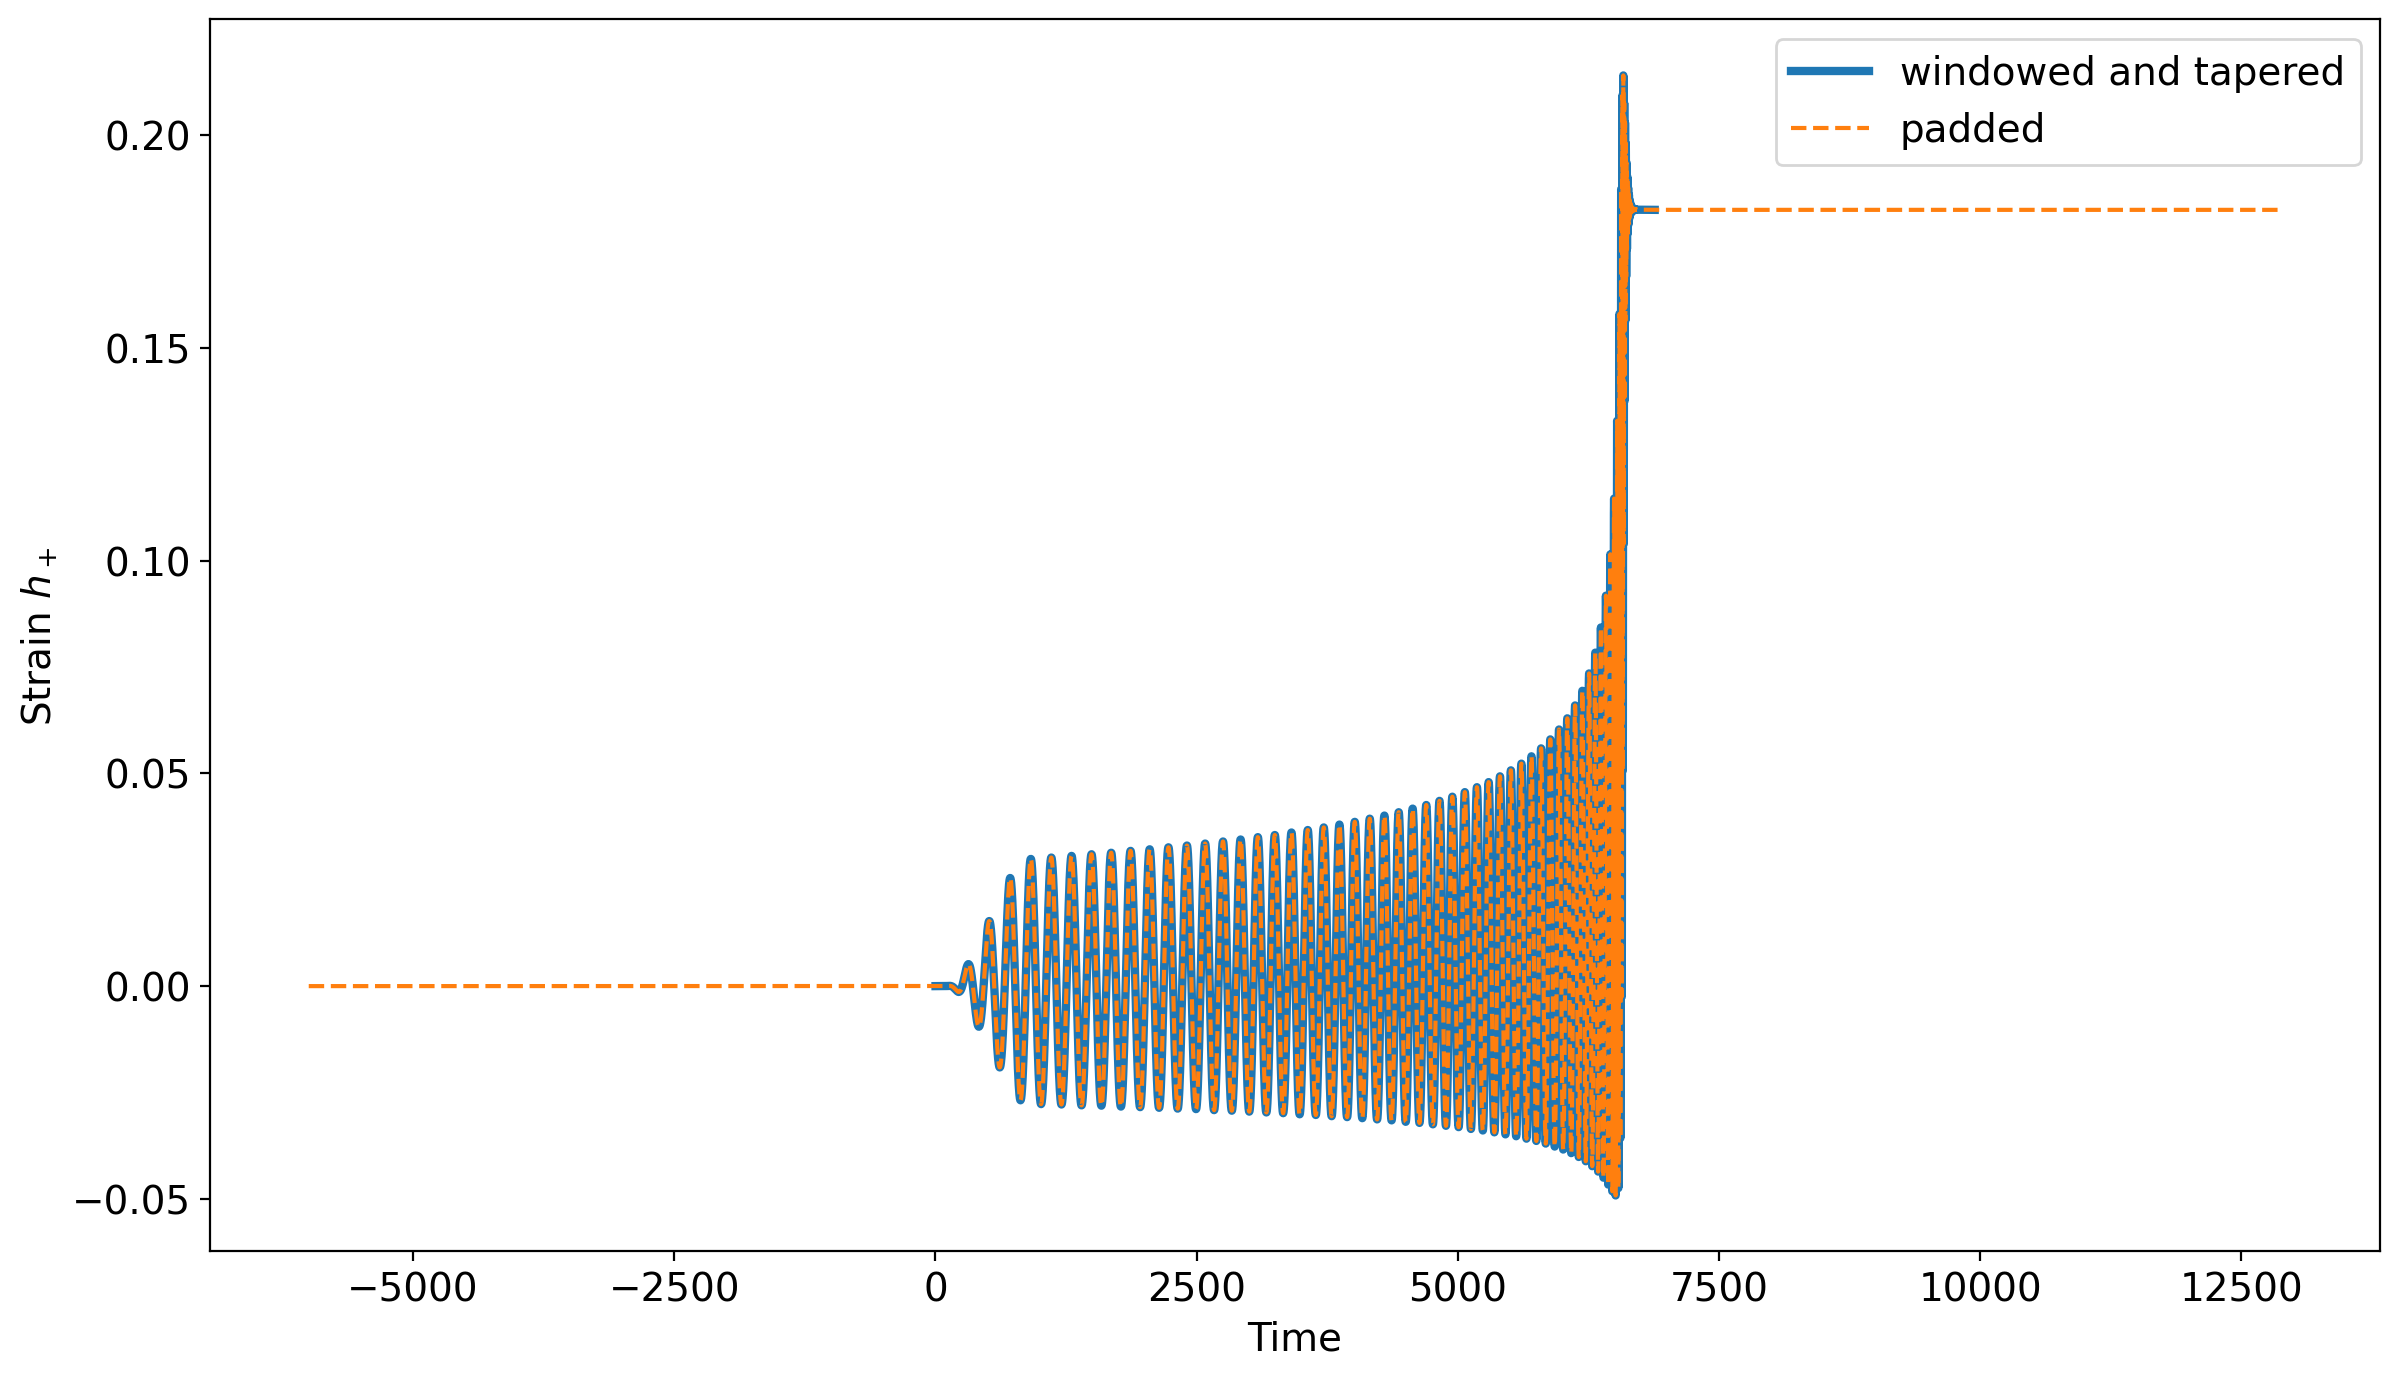

In [7]:
h_padded = h_transitioned.pad((6000.0, 6000.0))

plt.plot(h_transitioned.t, h_transitioned.real, lw=3, label="windowed and tapered")
plt.plot(h_padded.t, h_padded.real, ls="--", label="padded")
plt.xlabel("Time")
plt.ylabel("Strain $h_+$")
plt.legend();

# Line subtraction

As explained in [the paper](https://arxiv.org/abs/2405.06197), the presence of memory invalidates the assumptions of the shift theorem, which forms the basis for the matched-filtering technique that is fundamental to gravitational-wave astronomy detection efforts.  To work around this, we can remove a linear trend from the data.  This is done by subtracting the line connecting the first and last points of the data.  This is *similar* to the `detrend` operation frequently seen in signal processing, but not quite the same.  Therefore, to avoid ambiguity, we call this operation "line subtraction".

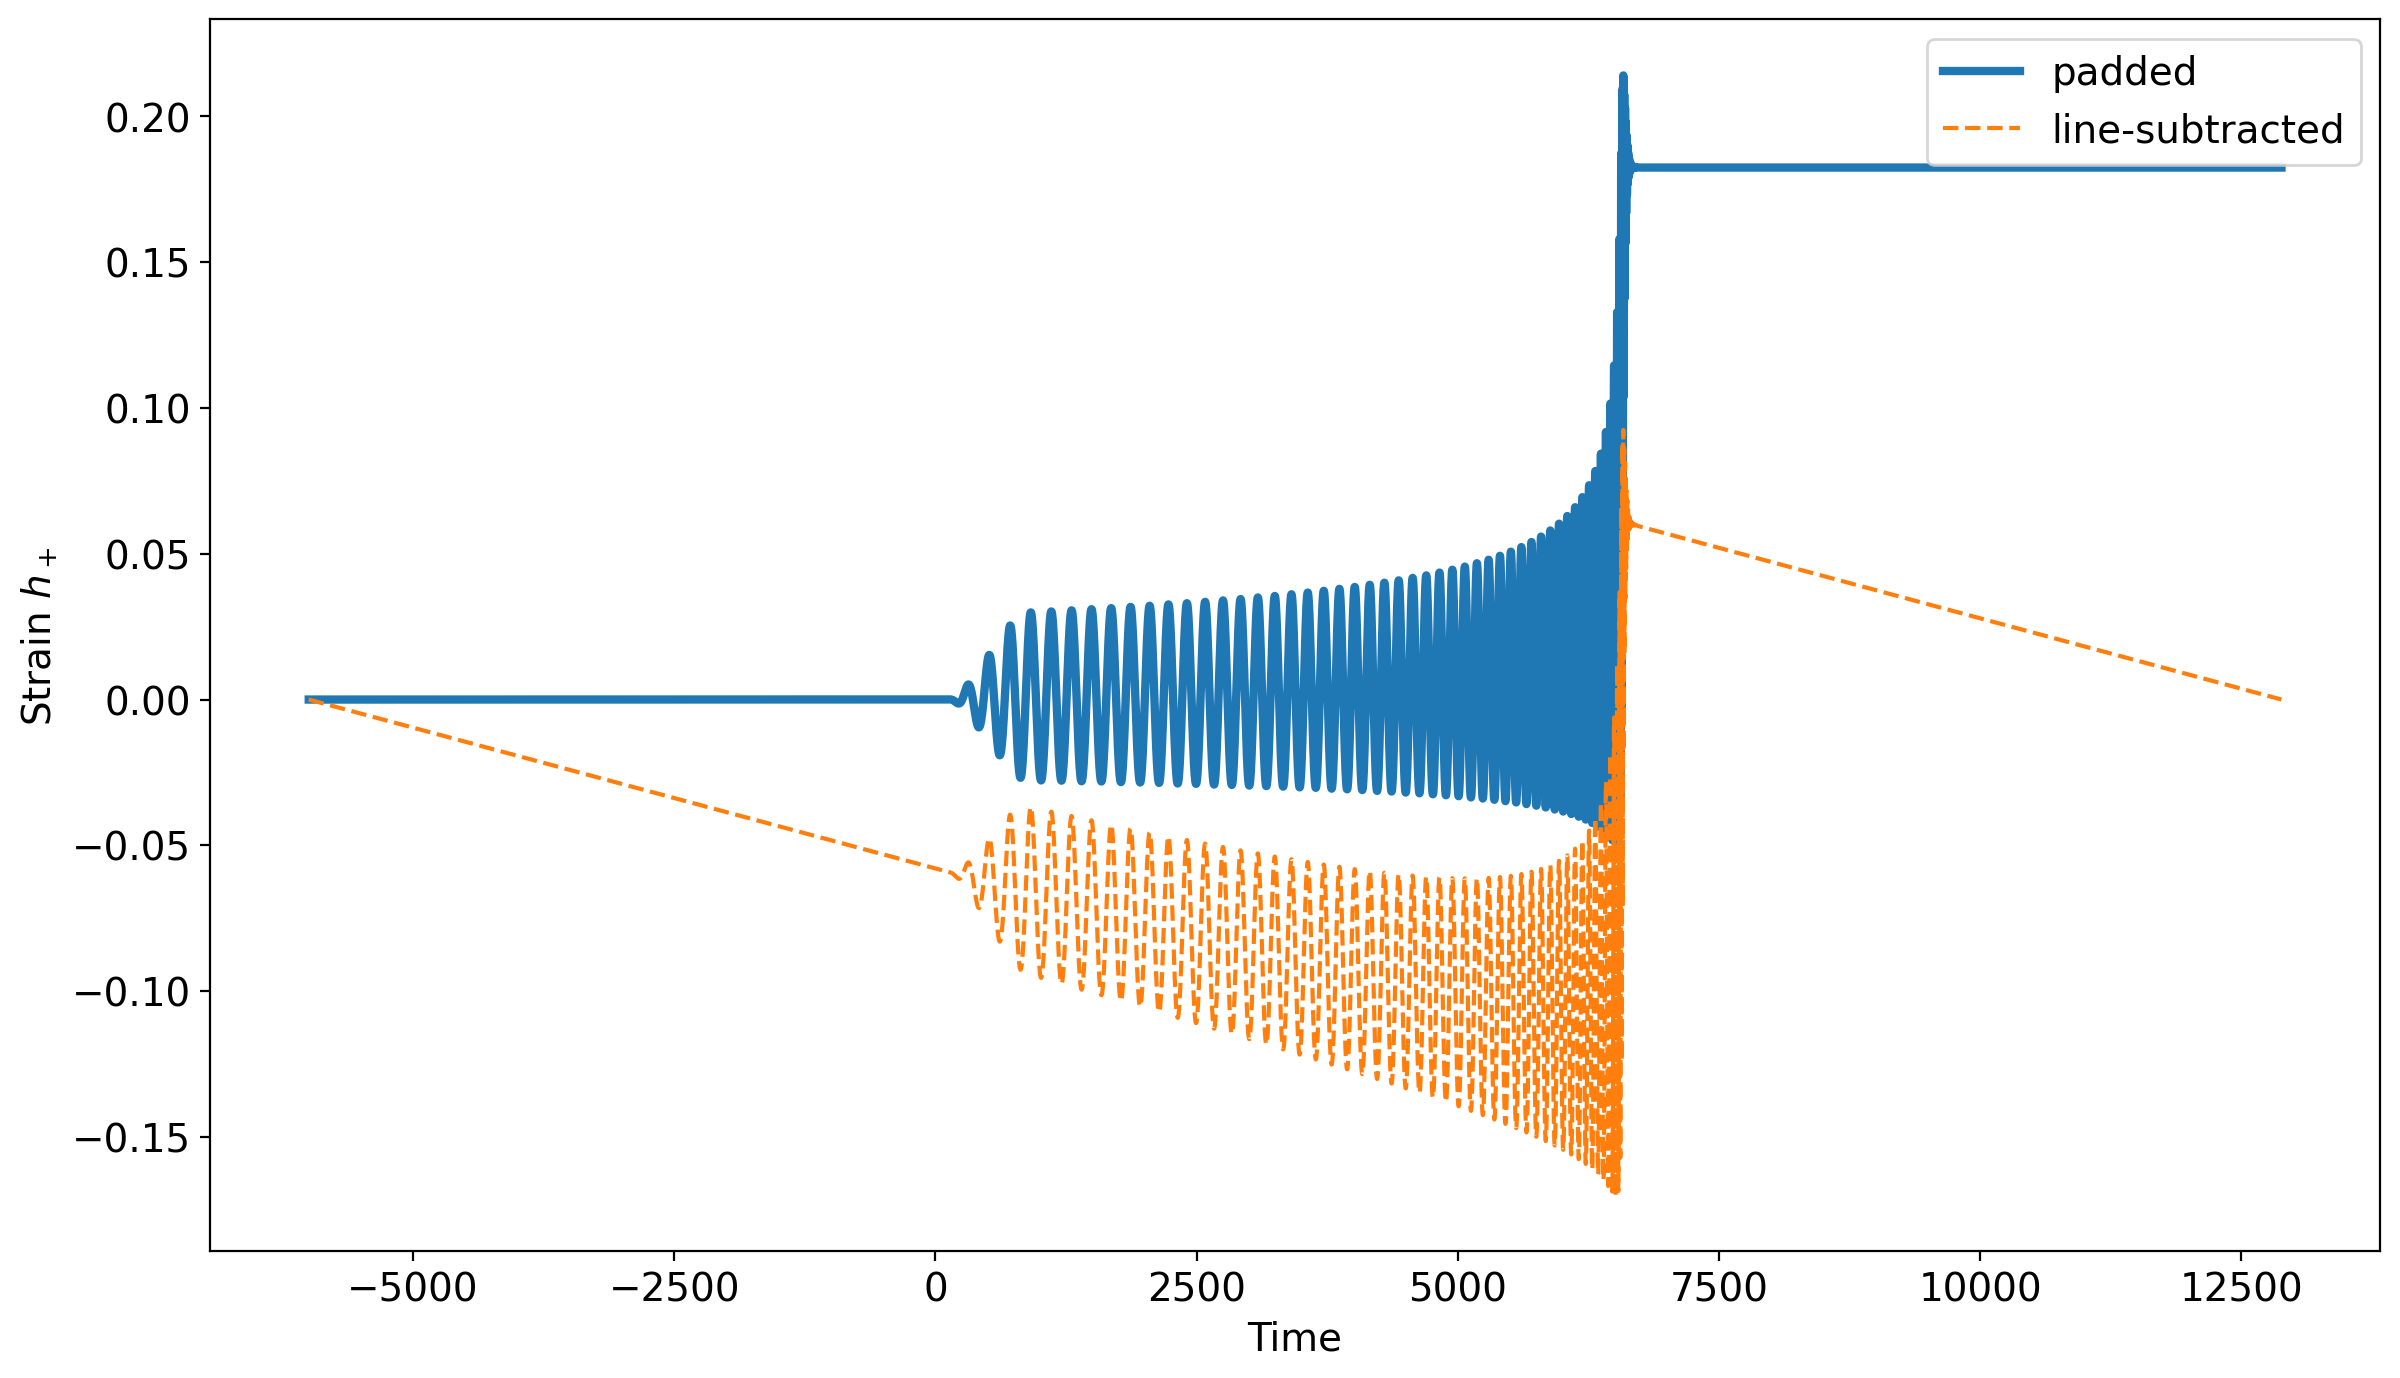

In [8]:
h_line_subtracted = h_padded.line_subtraction()

plt.plot(h_padded.t, h_padded.real, lw=3, label="padded")
plt.plot(h_line_subtracted.t, h_line_subtracted.real, ls="--", label="line-subtracted")
plt.xlabel("Time")
plt.ylabel("Strain $h_+$")
plt.legend();

# Putting it all together

As mentioned above, all of these steps can be performed at once by the `preprocess` method of waveforms loaded by the `sxs` package.  Though the default values are slightly different from the ones chosen above, they are generally consistent.

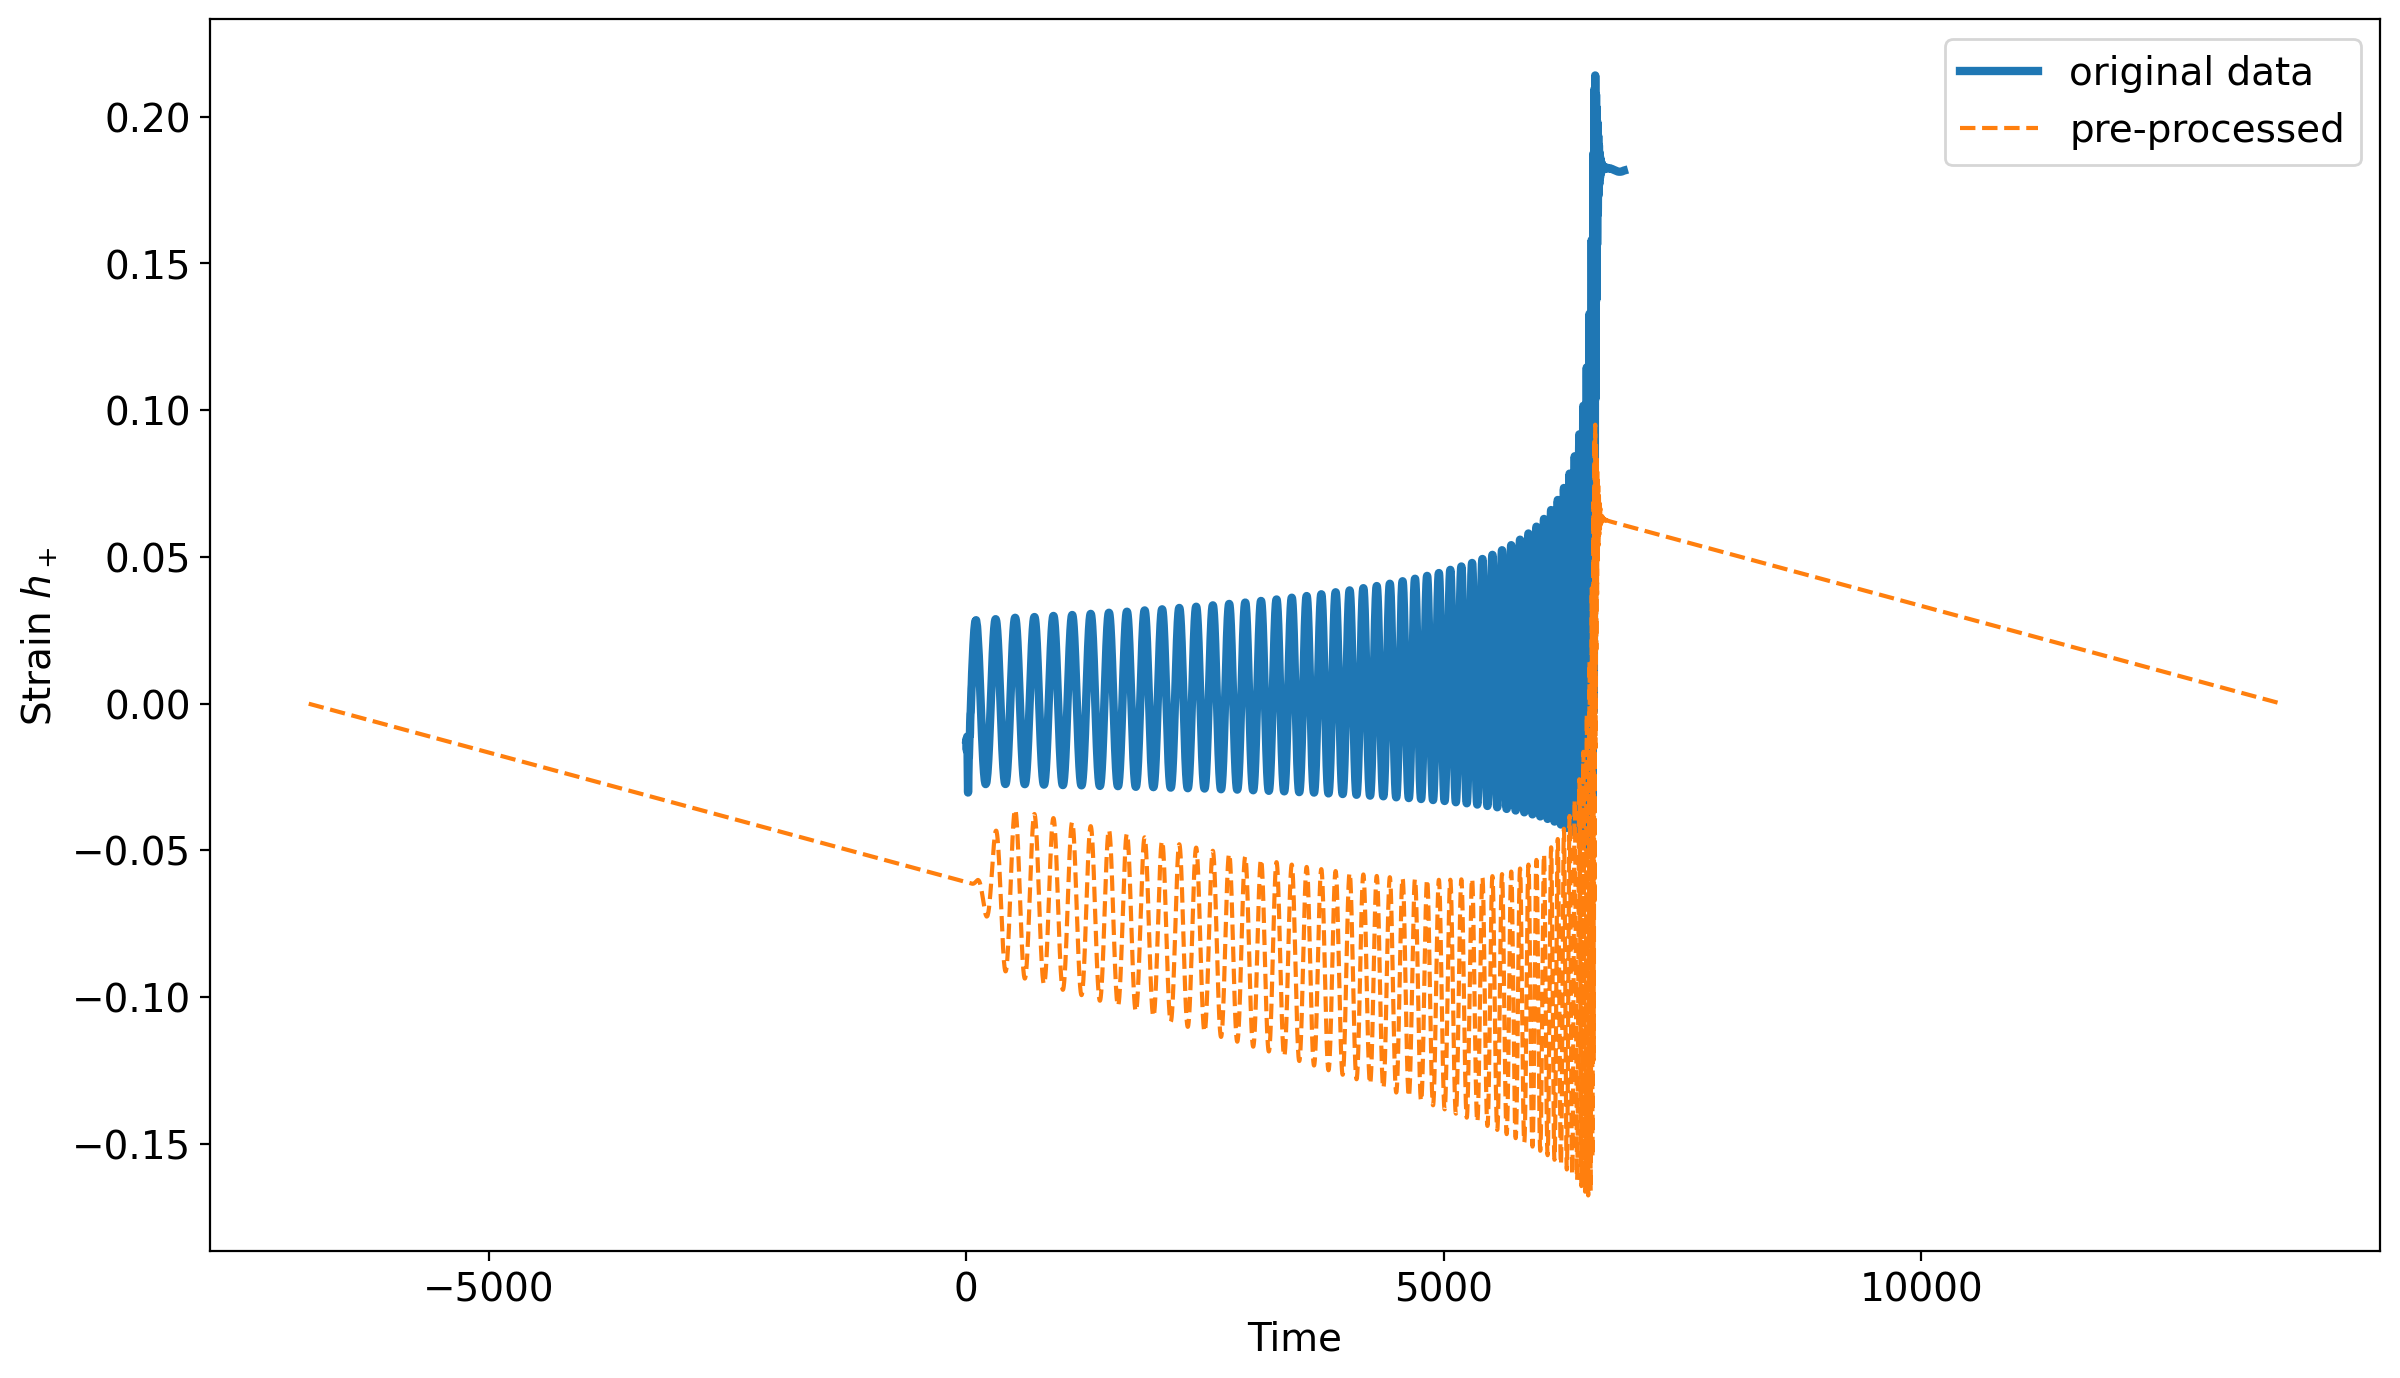

In [9]:
h_preprocessed = w.preprocess(evaluate_directions=(θ, ϕ))

plt.plot(h.t, h.real, lw=3, label="original data")
plt.plot(h_preprocessed.t, h_preprocessed.real, ls="--", label="pre-processed")
plt.xlabel("Time")
plt.ylabel("Strain $h_+$")
plt.legend();

The pre-processed signal may look pretty strange, but it has two *very* important features: the signal is periodic, and the signal is smooth.  As explained in [the paper](https://arxiv.org/abs/2405.06197), this results in frequency-domain data that more accurately reflects the true physical signal.  But these features would not be present with standard signal-processing techniques.